In [37]:
import os
import h5py
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.colors as mcolors
import numpy as np
from iminuit import minuit
from iminuit.cost import LeastSquares
import pandas as pd
from scipy import constants

matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [363]:
parent = r'C:\Users\ricca\Desktop\MAGISTRALE\QTLab2324\IRdetection\Test_data\data_20_02_set2'

In [364]:
def reader(parent):

    data = {
        "res1" : [],
        "res2" : [],
        "res3" : [],
        "res4" : []
    }

    for folder in os.listdir(parent):
        if folder.startswith("T"):
            T = folder.replace('T_','')
            for file in os.listdir(parent + '/' + folder):
                dic = {
                    'F' : [],
                    'I' : [],
                    'Q' : [],
                }
                with h5py.File(parent + '/' + folder + '/' + file, 'r') as f:
                    dic['F'] = np.array(f['raw_data']['f'][:])
                    dic['I'] = np.array(f['raw_data']['i'][:])
                    dic['Q'] = np.array(f['raw_data']['q'][:])
                    if '1' in file:
                        data['res1'].append([T, dic])
                    elif '2' in file:
                        data['res2'].append([T, dic])
                    elif '3' in file:
                        data['res3'].append([T, dic])
                    elif '4' in file:
                        data['res4'].append([T, dic])
    
    return data 

In [365]:
data = reader(parent)
polyorder = 2

In [366]:
def resonance_model(x, pars):
    return 1-pars[1]*np.exp(1j*pars[2])/(1-1j*((2*x*pars[0])-pars[3]))

def model(x, *pars):
    pol = np.polyval(pars[:polyorder+1], x)
    res = resonance_model(x, pars[polyorder+1:])
    return np.abs(res)+pol



In [367]:
p0 = [1e-6,1e-3,1,1e4, 0.5, 1, 0]

In [510]:
T = []
for i in range(len(data['res3'])):
    T.append(data['res3'][i][0])

In [511]:
def compute_Qi_err(Q, R, phi, sQ, sR, sphi):
    a = ((1-R*np.cos(phi))/Q**2)**2*sQ**2
    b = ((1-np.cos(phi))/Q)**2*sR**2
    c = ((1+R*np.sin(phi))*R/Q)**2*sphi**2
    return np.sqrt(a+b+c)

def compute_Qc_err(Q, R, phi, sQ, sR, sphi):
    a = 1/(R*np.cos(phi))**2*sQ**2
    b = (Q/(R**2*np.cos(phi))**2)**2*sR**2
    c = (Q*np.sin(phi)/(R*np.cos(phi)**2))**2*sphi**2
    return np.sqrt(a+b+c)

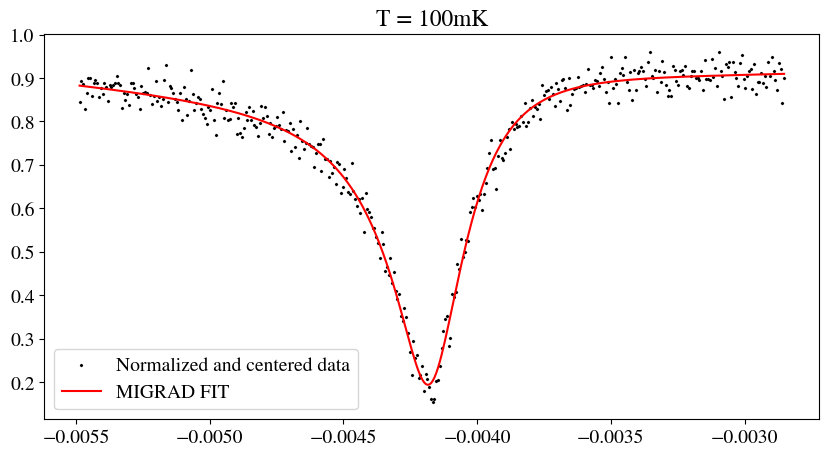

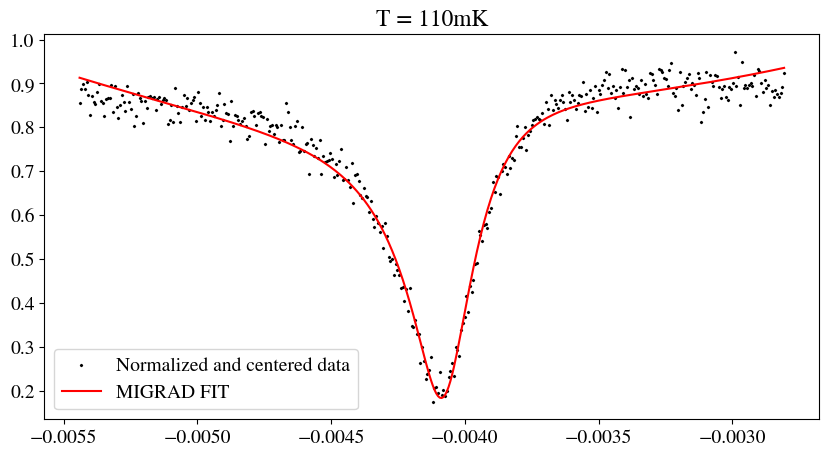

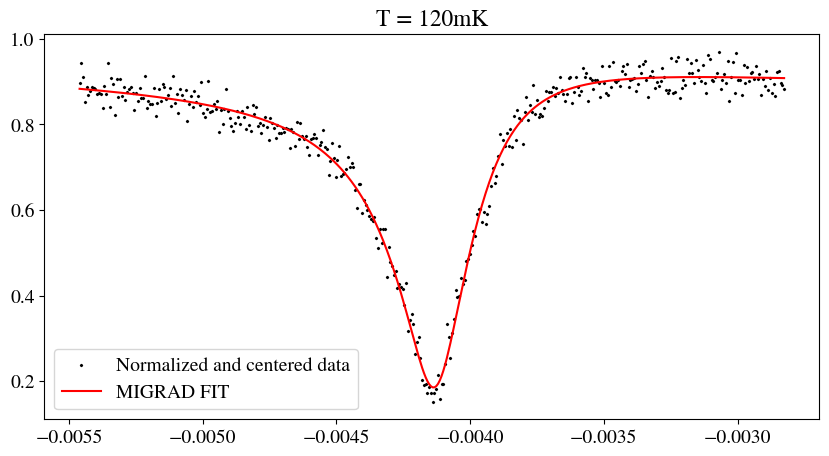

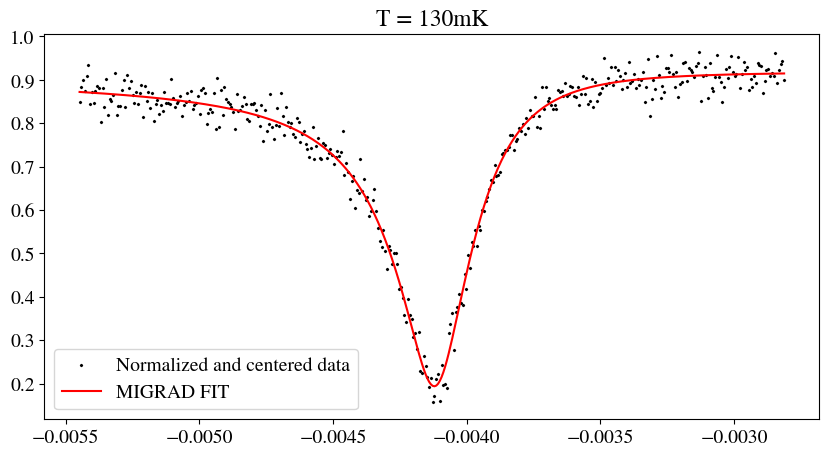

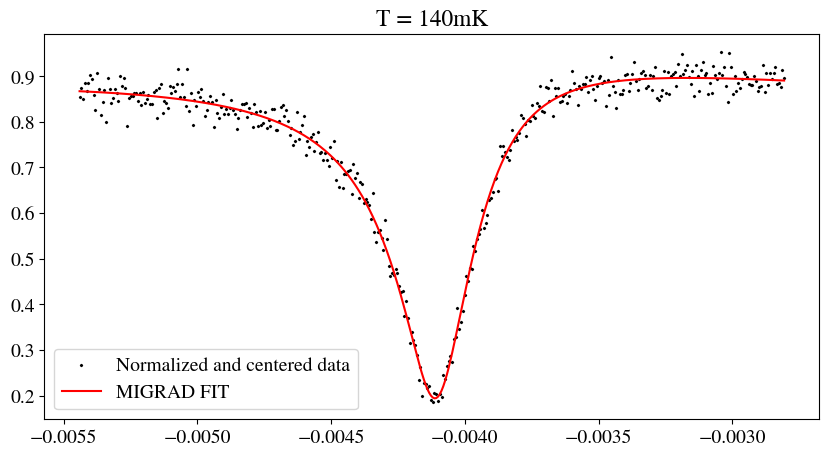

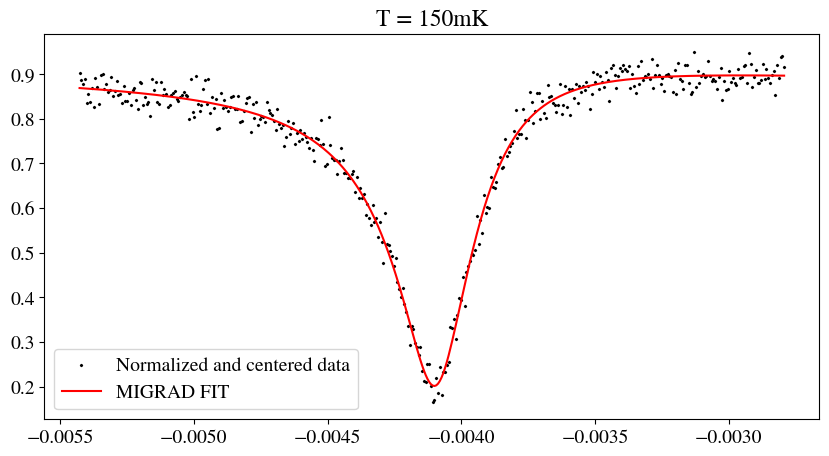

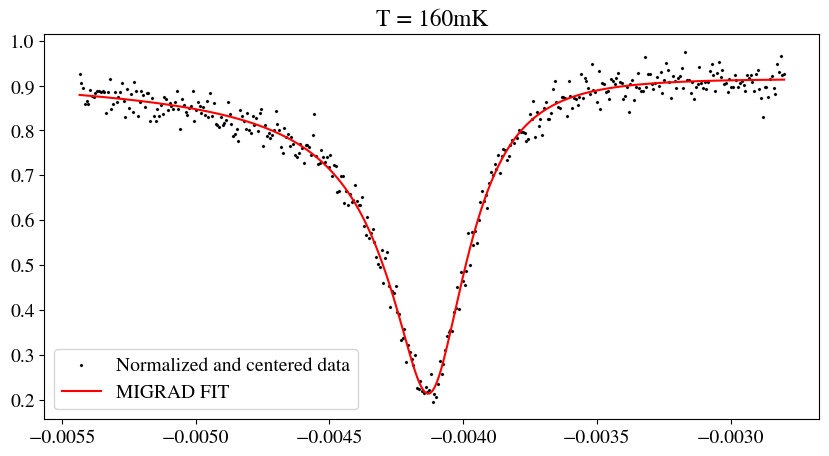

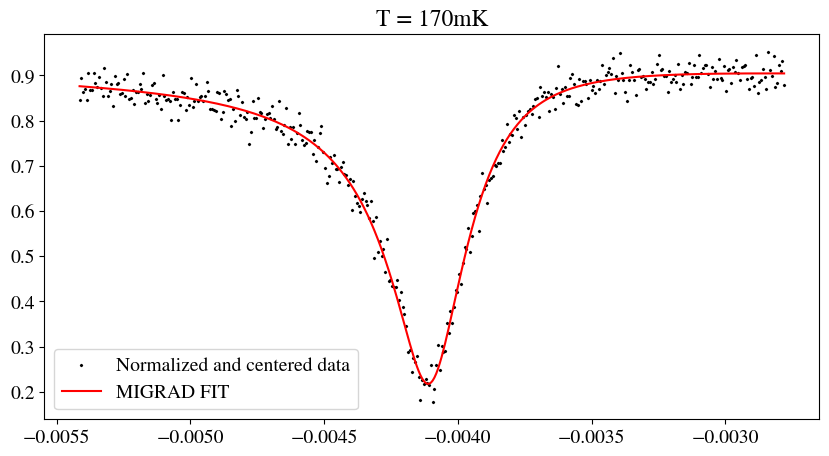

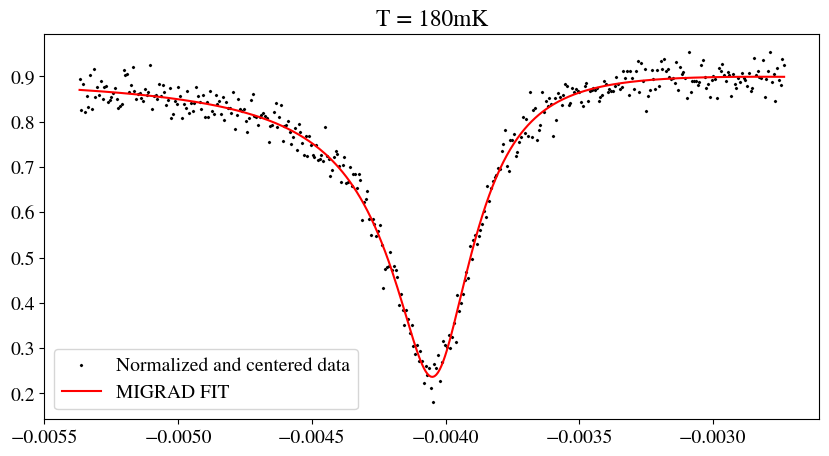

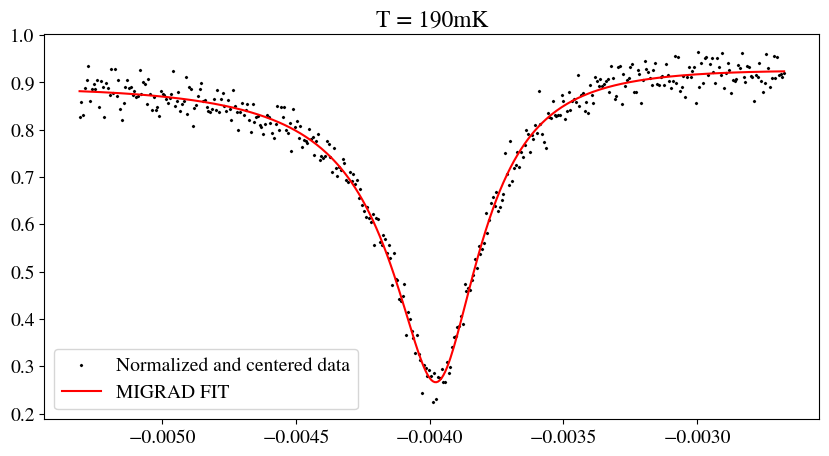

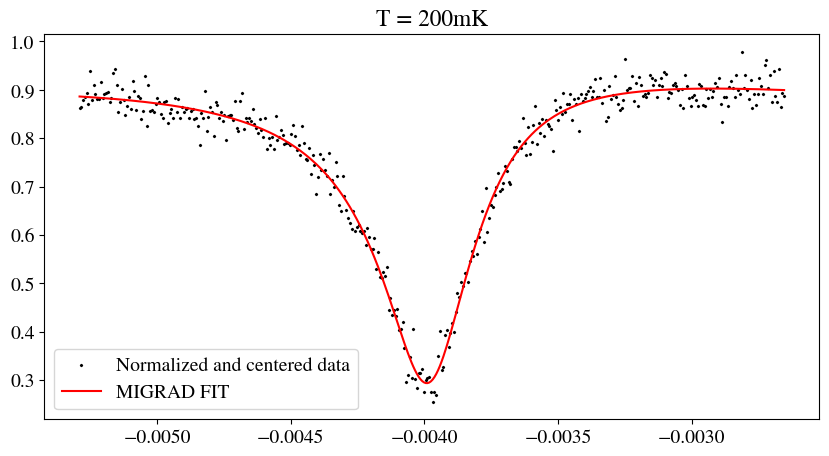

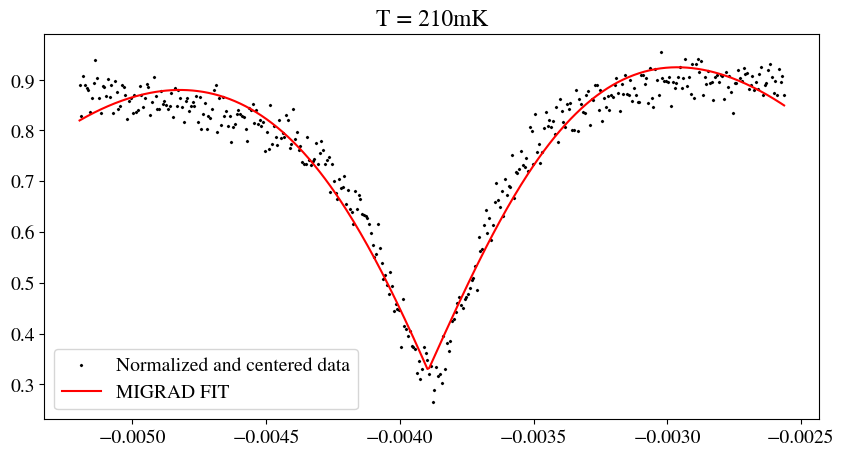

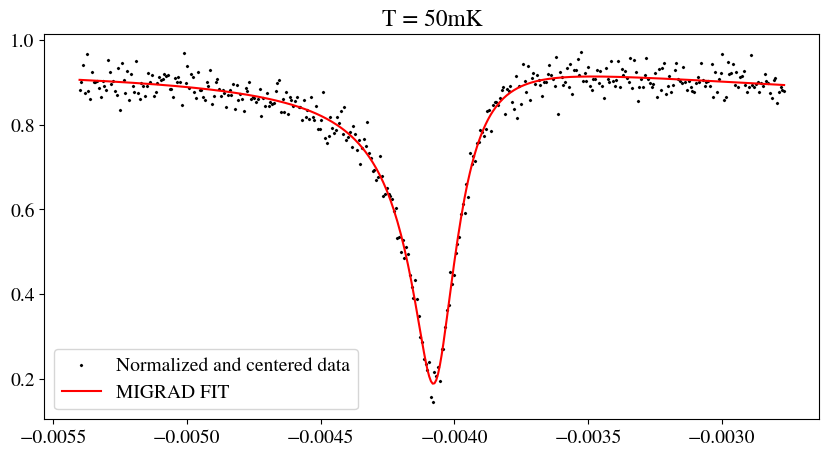

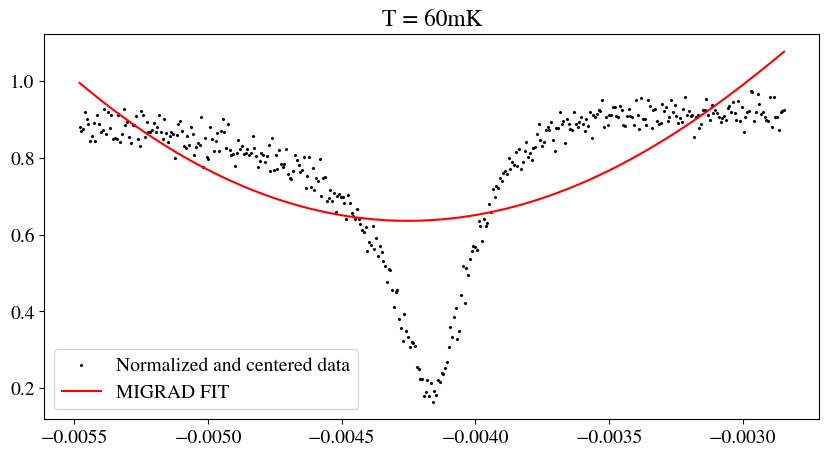

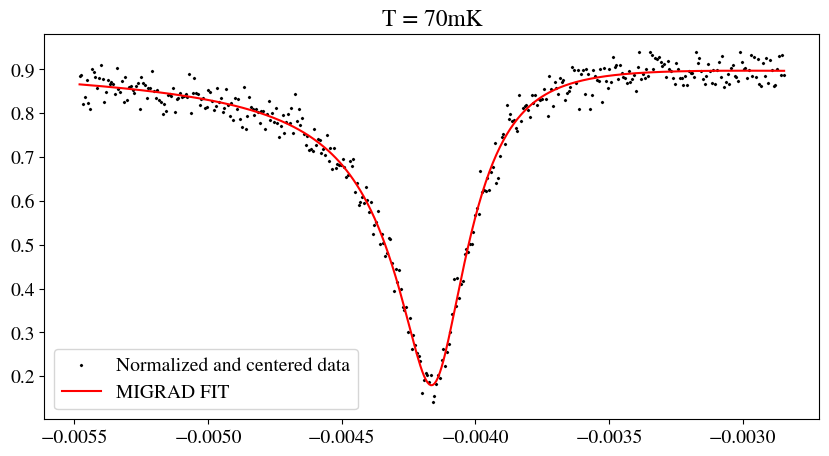

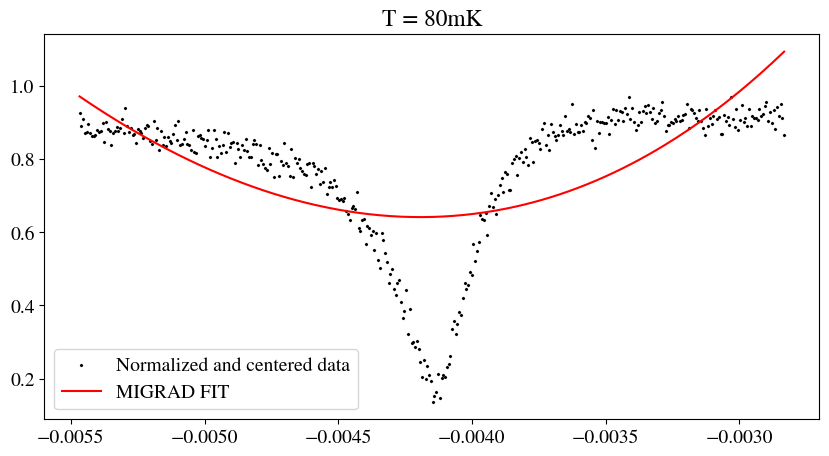

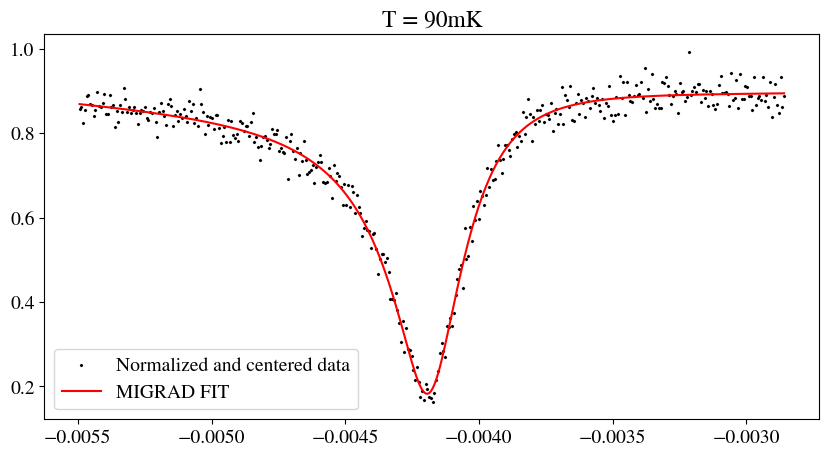

In [512]:
dic = {
    'Q' : [],
    'sQ' : [],
    'Qc' : [],
    'sQc' : [],
    'Qi' : [],
    'sQi' : [],
    'T' : []
}
prob = []
for i in range(len(T)): 
    fig, axs = plt.subplots(1,1,figsize=(10,5))
    F = np.array(data['res3'][i][1]['F'])
    C = np.array(data['res3'][i][1]['Q'])+1j*np.array(data['res3'][i][1]['I'])
    A = np.abs(C)
    P = np.unwrap(np.angle(C))
    A /= max(A)
    F = (F - F[np.argmin(A)])/F[np.argmin(A)]
    a = np.polyfit(F,P,1)
    P = P - np.polyval(a,F)
    A = A[np.argmin(A)-200:np.argmin(A)+200]
    F = F[np.argmin(A)-200:np.argmin(A)+200]
    P = P[np.argmin(A)-200:np.argmin(A)+200]
    len_fit = int(np.floor(len(A)/10))
    pol_amp = np.polyfit(F[:len_fit], A[:len_fit], 2)
    A_rms = np.sqrt(np.mean((np.polyval(pol_amp, F[:len_fit])-A[:len_fit])**2))        


    len_fit = int(np.floor(len(P)/10))
    pol_ph = np.polyfit(F[:len_fit], P[:len_fit], 2)
    P_rms = np.sqrt(np.mean((np.polyval(pol_ph, F[:len_fit])-P[:len_fit])**2))

    p0 = [1e-6,1e-3,1,1e4, 0.5, 1, 0]

    lsq = LeastSquares(F,A,A_rms*np.ones(len(A)),model)
    m= minuit.Minuit(lsq, *p0)
    ##m.limits['x3'] = (0,1e4)
    #m.limits['x4'] = (0,10)
    m.migrad(ncall=10000, iterate=1000)

    #plt.errorbar(F,A,np.ones_like(A)*A_rms,linestyle='')
    axs.scatter(F,A,s=2,marker='x',color='black',label='Normalized and centered data');
    axs.plot(F,model(F,*m.values),color='red',label='MIGRAD FIT');
    axs.set_title('T = '+str(T[i])+'mK')
    axs.legend()
    fig.savefig(r'C:\Users\ricca\Desktop\MAGISTRALE\QTLab2324\IRdetection\Notebooks\pngs\res1_'+str(T[i])+'.png')
    Q = m.values[polyorder+1]
    R = m.values[polyorder+2]
    phi = m.values[polyorder+3]
    Qi = Q/(1-R*(np.cos(phi)))
    Qc = Q/(R*(np.cos(phi)))

    if (Qi>0 and Q>0 and Qc>0 and m.fval/m.ndof < 2):
        dic['Qi'].append(float(1/Qi))
        dic['sQi'].append(compute_Qi_err(Q,R,phi,m.errors[polyorder+1],m.errors[polyorder+2],m.errors[polyorder+3]))
        dic['Q'].append(float(Q))
        dic['sQ'].append(float(m.errors[polyorder+1]))
        dic['Qc'].append(float(Qc))
        dic['sQc'].append(compute_Qc_err(Q,R,phi,m.errors[polyorder+1],m.errors[polyorder+2],m.errors[polyorder+3]))
        dic['T'].append(int(T[i]))
    else:
        prob.append(i)

In [513]:
print(len(prob))

10


In [583]:
i = prob[9]
print(T[i])
F = np.array(data['res1'][i][1]['F'])
C = np.array(data['res1'][i][1]['Q'])+1j*np.array(data['res1'][i][1]['I'])
A = np.abs(C)
P = np.unwrap(np.angle(C))
A /= max(A)
F = (F - F[np.argmin(A)])/F[np.argmin(A)]
a = np.polyfit(F,P,1)
P = P - np.polyval(a,F)
A = A[np.argmin(A)-400:np.argmin(A)+400]
F = F[np.argmin(A)-400:np.argmin(A)+400]
P = P[np.argmin(A)-400:np.argmin(A)+400]

90


In [584]:
p0 = [-800,-18,-0.1,12e2, 0.9, 6.3, -6.90]

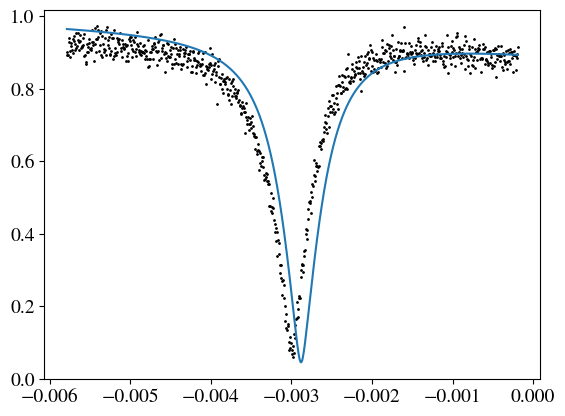

In [585]:
plt.scatter(F,A,color='black',s=1)
plt.plot(F,model(F,*p0))
Qi = Q/(1-R*(np.cos(phi)))

In [586]:
lsq = LeastSquares(F,A,A_rms*np.ones(len(A)),model)
m= minuit.Minuit(lsq, *p0)
m.limits['x3'] = (0,1e4)
m.limits['x4'] = (0,10)
m.migrad(ncall=10000, iterate=1000);

Q = m.values[polyorder+1]
R = m.values[polyorder+2]
phi = m.values[polyorder+3]
Qi = Q/(1-R*(np.cos(phi)))
Qc = Q/(R*(np.cos(phi)))
print(Qi)

7813.200558814422


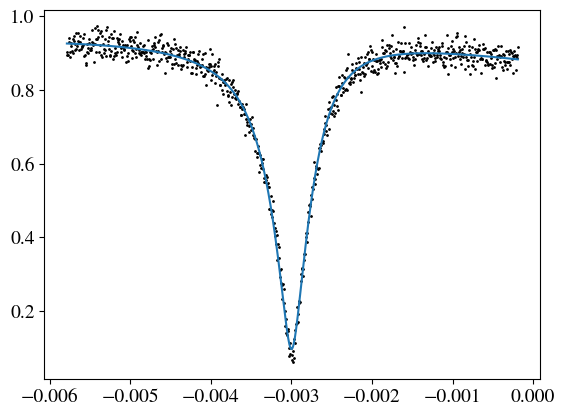

In [587]:
plt.scatter(F,A,color='black',s=1)
plt.plot(F,model(F,*m.values))

In [588]:
dic['Qi'].append(float(1/Qi))
dic['sQi'].append(compute_Qi_err(Q,R,phi,m.errors[polyorder+1],m.errors[polyorder+2],m.errors[polyorder+3]))
dic['Q'].append(float(Q))
dic['sQ'].append(float(m.errors[polyorder+1]))
dic['Qc'].append(float(Qc))
dic['sQc'].append(compute_Qc_err(Q,R,phi,m.errors[polyorder+1],m.errors[polyorder+2],m.errors[polyorder+3]))
dic['T'].append(int(T[i]))

In [589]:
sorted_indices = np.argsort(dic['T'])
dic['T'] = [dic['T'][i] for i in sorted_indices] 
dic['Q'] = [dic['Q'][i] for i in sorted_indices] 
dic['Qc'] = [dic['Qc'][i] for i in sorted_indices]
dic['Qi'] = [dic['Qi'][i] for i in sorted_indices]


df = pd.DataFrame(dic)
df_sorted = df.sort_values(by='T')
df_sorted.reset_index(drop=True, inplace=True)

print(df)

              Q         sQ           Qc         sQc        Qi       sQi    T
0   3475.844003  42.278210  4843.540231   81.104532  0.000081  0.000006   50
1   1286.348157  40.650182  1520.314960   81.659623  0.000120  0.000006   60
2   1272.938457  34.946417  1471.691294   73.013410  0.000106  0.000005   70
3   1300.457759  34.821047  1547.399343   71.974425  0.000123  0.000005   80
4   1277.760903  43.682046  1527.579280   97.920047  0.000128  0.000007   90
5   1291.882706  40.822776  1545.721523  103.414792  0.000127  0.000008  100
6   1292.038879  74.168130  1551.279145  155.556876  0.000129  0.000004  110
7   2169.880160  12.457175  3022.748410   19.553467  0.000130  0.000004  120
8   1286.352336  12.372445  1531.565470   19.589430  0.000124  0.000004  130
9   2124.898150  12.312569  3003.942652   19.228279  0.000138  0.000004  140
10  2116.612062  12.168762  3057.633818   20.589067  0.000145  0.000004  150
11  2070.058848  11.674526  2998.523528   20.639027  0.000150  0.000005  160

In [590]:
df.to_csv('20_02_set2_res3.txt','\t')

C:\Users\ricca\AppData\Local\Temp\ipykernel_11212\2371568693.py:1: FutureWarning: Starting with pandas version 3.0 all arguments of to_csv except for the argument 'path_or_buf' will be keyword-only.
  df.to_csv('20_02_set2_res3.txt','\t')
